In [1]:
import torch
import torchvision
import torchvision.transforms as T
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, random
from torchvision.transforms import Normalize
import cv2
import time
import copy
from tqdm import tqdm
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


c:\Users\PC\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

class Unnormalize:
    """Converts an image tensor that was previously Normalize'd
    back to an image with pixels in the range [0, 1]."""
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        mean = torch.as_tensor(self.mean, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        std = torch.as_tensor(self.std, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        return torch.clamp(tensor*std + mean, 0., 1.)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)
unnormalize_transform = Unnormalize(mean, std)

In [3]:
image_size = 224
batch_size = 64
metadata=pd.read_csv(r"C:\\Users\\PC\Desktop\\CS464\\face-verification\\archive\\metadata.csv")
crops_dir=r"C:\\Users\\PC\Desktop\\CS464\\face-verification\\archive\\faces_224"

# def random_hflip(img, p=0.5):
#     """Random horizontal flip."""
#     if random.random() < p:
#         return cv2.flip(img, 1)
#     else:
#         return img

In [4]:
def random_hflip(img, p=1):
    """Random horizontal flip."""
    if random.random() < p:
        return cv2.flip(img, 1)
    else:
        return img

def rotate(image, angle=90, scale=1.0):
    '''
    Rotate the image
    :param image: image to be processed
    :param angle: Rotation angle in degrees. Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
    :param scale: Isotropic scale factor.
    '''
    w = image.shape[1]
    h = image.shape[0]
    #rotate matrix
    M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
    #rotate
    image = cv2.warpAffine(image,M,(w,h))
    return image

In [5]:
# def load_image_and_label(filename, cls, crops_dir, image_size, augment):
#     """Loads an image into a tensor. Also returns its label."""
#     img = cv2.imread(os.path.join(crops_dir, filename))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     if augment: 
#         img = random_hflip(img)

#     img = cv2.resize(img, (image_size, image_size))

#     img = torch.tensor(img).permute((2, 0, 1)).float().div(255)
#     img = normalize_transform(img)

#     target = 1 if cls == "FAKE" else 0
#     return img, target
def load_image_and_label(filename, cls, crops_dir, image_size, augment=0):
    """Loads an image into a tensor. Also returns its label."""
    img = cv2.imread(os.path.join(crops_dir, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if cls== "REAL":
        if augment==1: 
        
            img = cv2.flip(img,1)
        
        elif augment==2:
        
            img=cv2.flip(img,0)
        
        elif augment==3:
        
            img=rotate(img,90,1.0)    
        
        elif augment==4:
        
            img=rotate(img,270,1.0)   

    img = cv2.resize(img, (image_size, image_size))

    img = torch.tensor(img).permute((2, 0, 1)).float().div(255)
    img = normalize_transform(img)

    target = 1 if cls == "FAKE" else 0
    return img, target

In [6]:
class VideoDataset(Dataset):
    """Face crops dataset.

    Arguments:
        crops_dir: base folder for face crops
        df: Pandas DataFrame with metadata
        split: if "train", applies data augmentation
        image_size: resizes the image to a square of this size
        sample_size: evenly samples this many videos from the REAL
            and FAKE subfolders (None = use all videos)
        seed: optional random seed for sampling
    """
    def __init__(self, crops_dir, df, split, image_size,augment=False, oversample=False, sample_size=None, seed=None):
        self.crops_dir = crops_dir
        self.split = split
        self.image_size = image_size
        self.augment=augment
        self.oversample = oversample
        
        if sample_size is not None:
            real_df = df[df["label"] == "REAL"]
            fake_df = df[df["label"] == "FAKE"]
            sample_size = np.min(np.array([sample_size, len(real_df), len(fake_df)]))
            print("%s: sampling %d from %d real videos" % (split, sample_size, len(real_df)))
            print("%s: sampling %d from %d fake videos" % (split, sample_size, len(fake_df)))
            real_df = real_df.sample(sample_size, random_state=seed)
            fake_df = fake_df.sample(sample_size, random_state=seed)
            self.df = pd.concat([real_df, fake_df])
            self.df['aug'] = np.zeros((len(self.df), 1))
        elif self.augment:
            real_df = df[df["label"] == "REAL"]
            real_df["aug"]=np.zeros((len(real_df),1))
            
            real_df1=real_df.copy()
            real_df1["aug"]=np.ones((len(real_df),1))
            
            real_df2=real_df.copy()
            real_df2["aug"]=np.ones((len(real_df),1))*2
            
            real_df3=real_df.copy()
            real_df3["aug"]=np.ones((len(real_df),1))*3
            
            real_df4=real_df.copy()
            real_df4["aug"]=np.ones((len(real_df),1))*4
            
            fake_df = df[df["label"] == "FAKE"]
            fake_df["aug"]=np.zeros((len(fake_df),1))
            
            self.df = pd.concat([real_df, real_df1, real_df2, real_df3, real_df4, fake_df])
        elif self.oversample: # oversample the real data
            real_df = df[df["label"] == "REAL"] 
            fake_df = df[df["label"] == "FAKE"]
            
            real_df1 = real_df.copy()
            real_df2 = real_df.copy()
            real_df3 = real_df.copy()
            real_df4 = real_df.copy()
            self.df = pd.concat([real_df, real_df1, real_df2, real_df3, real_df4, fake_df])
            self.df['aug'] = np.zeros((len(self.df), 1))
        else:
            self.df = df
            self.df['aug'] = np.zeros((len(self.df), 1))

        num_real = len(self.df[self.df["label"] == "REAL"])
        num_fake = len(self.df[self.df["label"] == "FAKE"])
        print("%s dataset has %d real videos, %d fake videos" % (split, num_real, num_fake))

    def __getitem__(self, index):
        row = self.df.iloc[index]
        filename = row["videoname"][:-4] + ".jpg"
        cls = row["label"]
        return load_image_and_label(filename, cls, self.crops_dir, 
                                    self.image_size, row["aug"])
    def __len__(self):
        return len(self.df)

In [7]:
def make_splits(crops_dir, metadata_df, frac):
    # Make a validation split. Sample a percentage of the real videos, 
    # and also grab the corresponding fake videos.
    frac=frac*2
    real_rows = metadata_df[metadata_df["label"] == "REAL"]
    real_df = real_rows.sample(frac=frac, random_state=666)
    fake_df = metadata_df[metadata_df["original"].isin(real_df["videoname"])]
    r=len(real_df)
    f=len(fake_df)
    real_1=real_df[:int(r/2)]
    real_2=real_df[int(r/2):]
    fake_1=fake_df[:int(f/2)]
    fake_2=fake_df[int(f/2):]   
    val_df = pd.concat([real_1, fake_1])
    test_df=pd.concat([real_2, fake_2])

    #shuffle
    val_df=val_df.sample(frac=1,random_state=666)
    test_df=test_df.sample(frac=1,random_state=666)

    # The training split is the remaining videos.
    train_df = metadata_df.loc[~(metadata_df.index.isin( val_df.index) | metadata_df.index.isin( test_df.index))]

    return train_df, val_df, test_df

# def make_splits(crops_dir, metadata_df, frac):
#     # Make a validation split. Sample a percentage of the real videos, 
#     # and also grab the corresponding fake videos.
#     real_rows = metadata_df[metadata_df["label"] == "REAL"]
#     real_df = real_rows.sample(frac=1, random_state=666)
#     fake_df = metadata_df[metadata_df["original"].isin(real_df["videoname"])]
#     fake_df=fake_df.sample(frac=1,random_state=666)[:len(real_df)]
#     r=len(real_df)
#     f=len(fake_df)

#     real_1=real_df[:int(8*r/10)]
#     real_2=real_df[int(8*r/10):int(9*r/10)]
#     real_3=real_df[int(9*r/10):]
#     fake_1=fake_df[:int(8*r/10)]
#     fake_2=fake_df[int(8*r/10):int(9*r/10)]  
#     fake_3=fake_df[int(9*r/10):] 

#     val_df = pd.concat([real_2, fake_2])
#     test_df=pd.concat([real_3, fake_3])
#     train_df=pd.concat([real_1, fake_1])

#     train_df=train_df.sample(frac=1,random_state=666)
#     val_df=val_df.sample(frac=1,random_state=666)
#     test_df=test_df.sample(frac=1,random_state=666)
    
#     return train_df, val_df, test_df

In [8]:
def create_data_loaders(crops_dir, metadata_df, image_size, batch_size, num_workers=0):
    train_df, val_df,test_df = make_splits(crops_dir, metadata_df, frac=0.05)

    train_dataset = VideoDataset(crops_dir, train_df, "train", image_size,augment=False, oversample=True, sample_size=None)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                              num_workers=num_workers, pin_memory=True)

    val_dataset = VideoDataset(crops_dir, val_df, "val", image_size,augment=False, oversample=True, sample_size=None, seed=1234)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                            num_workers=num_workers, pin_memory=True)
    
    test_dataset = VideoDataset(crops_dir, test_df, "test", image_size, sample_size=None, seed=4321)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, 
                            num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader

In [9]:
train_loader, val_loader, test_loader = create_data_loaders(crops_dir, metadata, image_size, 
                                               batch_size, num_workers=0)

train dataset has 73320 real videos, 71562 fake videos
val dataset has 4070 real videos, 3889 fake videos
test dataset has 815 real videos, 3890 fake videos


In [10]:
dataloaders = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader
}
dataset_sizes = {
    "train": len(train_loader.dataset),
    "val": len(val_loader.dataset),
    "test": len(test_loader.dataset)
}

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
# """
#     Propsoed CNN architecture.
    
# """

# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()

#         # Pamameters Initialization
#         input_shape = (3,224,224)
#         activation = nn.Sigmoid()
#         padding = 1
#         droprate = 0.1
#         epsilon=0.001

#         self.layer1 = nn.Sequential(
#             nn.BatchNorm2d(num_features=input_shape[0]),
#             nn.Conv2d(in_channels=input_shape[0], out_channels=8, kernel_size=3, stride=1, padding=padding),
#             activation,
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(num_features=8, eps=epsilon)
#         )

#         self.layer2 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=padding),
#             activation,
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(num_features=16, eps=epsilon),
#             nn.Dropout2d(p=droprate)
#         )

#         self.layer3 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=padding),
#             activation,
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(num_features=32, eps=epsilon),
#             nn.Dropout2d(p=droprate)
#         )

#         self.layer4 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=padding),
#             activation,
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(num_features=64, eps=epsilon),
#             nn.Dropout2d(p=droprate)
#         )

#         self.layer5 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=padding),
#             activation,
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(num_features=128, eps=epsilon),
#             nn.Dropout2d(p=droprate)
#         )

#         self.layer6 = nn.Sequential(
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=padding),
#             activation,
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(num_features=256, eps=epsilon),
#             nn.Dropout2d(p=droprate)
#         )
#         self.layer7 = nn.Sequential(
#             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=padding),
#             activation,
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(num_features=512, eps=epsilon),
#             nn.Dropout2d(p=droprate)
#         )
#         self.layer8 = nn.Sequential(
#             nn.AdaptiveAvgPool2d(output_size=(1, 1)),
#             nn.Flatten(),
#             nn.Linear(512, 2),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.layer5(x)
#         x = self.layer6(x)
#         x = self.layer7(x)
#         x = self.layer8(x)

#         return x

# model = CNN()
"""
    Propsoed CNN architecture.
    
"""

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Pamameters Initialization
        input_shape = (3,224,224)
        activation = nn.LeakyReLU()
        padding = 2
        droprate = 0.1
        epsilon=0.001

        self.layer1 = nn.Sequential(
            nn.BatchNorm2d(num_features=input_shape[0]),
            nn.Conv2d(in_channels=input_shape[0], out_channels=8, kernel_size=3, stride=1, padding=padding),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=8, eps=epsilon)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=padding),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=16, eps=epsilon),
            nn.Dropout2d(p=droprate)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=padding),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=32, eps=epsilon),
            nn.Dropout2d(p=droprate)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=padding),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=64, eps=epsilon),
            nn.Dropout2d(p=droprate)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=padding),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=128, eps=epsilon),
            nn.Dropout2d(p=droprate)
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=padding),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=256, eps=epsilon),
            nn.Dropout2d(p=droprate)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=padding),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=512, eps=epsilon),
            nn.Dropout2d(p=droprate)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=padding),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=512, eps=epsilon),
            nn.Dropout2d(p=droprate)
        )
        self.layer9 = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(512, 2),
            nn.Sigmoid()
        )
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)

        return x

model = CNN()

In [13]:
torch.cuda.empty_cache()
torch.cuda.is_available()

True

In [14]:
model = model.to(device)

In [15]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [16]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5)

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 10):
    loss_train=[]
    acc_train=[]
    loss_val=[]
    acc_val=[]
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                loss_train.append(epoch_loss)
                acc_train.append(epoch_acc)
            else:
                loss_val.append(epoch_loss)
                acc_val.append(epoch_acc)



            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            loss_train.append(epoch_loss)
            acc_train.append(epoch_acc)
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, loss_train, acc_train, loss_val, acc_val

In [18]:
model_ft, lt,at,lv,av = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10) # now it is a lot faster

Epoch 0/9
----------


100%|██████████| 2264/2264 [06:47<00:00,  5.55it/s]


train Loss: 0.6326 Acc: 0.6602


100%|██████████| 125/125 [00:18<00:00,  6.91it/s]


val Loss: 0.6000 Acc: 0.7015

Epoch 1/9
----------


100%|██████████| 2264/2264 [06:17<00:00,  6.00it/s]


train Loss: 0.5713 Acc: 0.7491


100%|██████████| 125/125 [00:18<00:00,  6.60it/s]


val Loss: 0.5605 Acc: 0.7609

Epoch 2/9
----------


100%|██████████| 2264/2264 [05:56<00:00,  6.35it/s]


train Loss: 0.5364 Acc: 0.7929


100%|██████████| 125/125 [00:16<00:00,  7.70it/s]


val Loss: 0.5464 Acc: 0.7750

Epoch 3/9
----------


100%|██████████| 2264/2264 [05:58<00:00,  6.31it/s]


train Loss: 0.5128 Acc: 0.8228


100%|██████████| 125/125 [00:18<00:00,  6.86it/s]


val Loss: 0.5350 Acc: 0.7953

Epoch 4/9
----------


100%|██████████| 2264/2264 [07:02<00:00,  5.36it/s]


train Loss: 0.4950 Acc: 0.8451


100%|██████████| 125/125 [00:18<00:00,  6.92it/s]


val Loss: 0.5302 Acc: 0.7987

Epoch 5/9
----------


100%|██████████| 2264/2264 [05:59<00:00,  6.31it/s]


train Loss: 0.4694 Acc: 0.8768


100%|██████████| 125/125 [00:16<00:00,  7.45it/s]


val Loss: 0.5183 Acc: 0.8183

Epoch 6/9
----------


100%|██████████| 2264/2264 [05:48<00:00,  6.50it/s]


train Loss: 0.4615 Acc: 0.8863


100%|██████████| 125/125 [00:16<00:00,  7.69it/s]


val Loss: 0.5108 Acc: 0.8236

Epoch 7/9
----------


100%|██████████| 2264/2264 [05:53<00:00,  6.40it/s]


train Loss: 0.4564 Acc: 0.8922


100%|██████████| 125/125 [00:16<00:00,  7.48it/s]


val Loss: 0.5090 Acc: 0.8290

Epoch 8/9
----------


100%|██████████| 2264/2264 [05:49<00:00,  6.47it/s]


train Loss: 0.4532 Acc: 0.8963


100%|██████████| 125/125 [00:17<00:00,  7.17it/s]


val Loss: 0.5116 Acc: 0.8260

Epoch 9/9
----------


100%|██████████| 2264/2264 [05:54<00:00,  6.38it/s]


train Loss: 0.4498 Acc: 0.9003


100%|██████████| 125/125 [00:16<00:00,  7.45it/s]


val Loss: 0.5110 Acc: 0.8256

Training complete in 64m 25s
Best Val Acc: 0.8290


In [19]:
classes=['training_real', 'training_fake']

In [20]:
test_loss = 0.0
class_correct = list(0 for i in range(2))
class_total = list(0 for i in range(2))
model.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
   
    if torch.cuda.is_available():
      #model.cuda()
      model= model.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())

    for i in range(len(target)):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1

test_loss = test_loss / len(test_loader.dataset) #test_data_len
print('Test Loss: {:.4f}'.format(test_loss))


100%|██████████| 74/74 [00:14<00:00,  5.25it/s]

Test Loss: 0.0034


In [21]:
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

Test Accuracy of training_real: 78% (640/815)
Test Accuracy of training_fake: 86% (3350/3890)
Test Accuracy of 84% (3990/4705)


<function matplotlib.pyplot.show(close=None, block=None)>

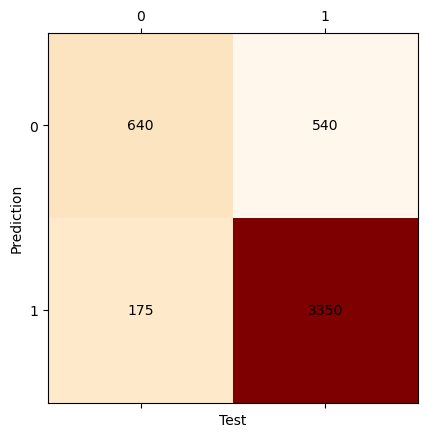

In [22]:
r1=[class_correct[0], class_total[0]-class_correct[0]]
r2= [-class_correct[1] +class_total[1],class_correct[1]]
conf=pd.DataFrame([r1,r2])

fig, ax = plt.subplots()
ax.matshow(conf,cmap='OrRd')

ax.set(xlabel='Test', ylabel='Prediction')

for i in range(2):
  for j in range(2):
    c = conf[j][i]
    ax.text(i, j, str(c), va='center', ha='center')
plt.show

In [23]:
at2=[at[a] for a in range(len(at)) if a % 3 == 1 ]
lt2=[lt[a] for a in range(len(lt)) if a % 3 == 1 ]
at3=[at2[a].item() for a in range(len(at2)) ]
av3=[av[a].item() for a in range(len(av)) ]

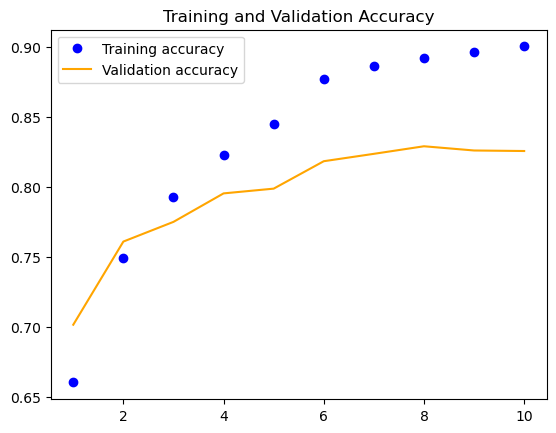

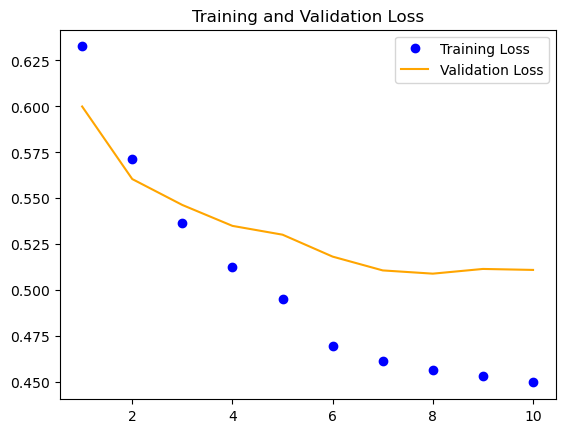

In [24]:
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show();
plot_accuracy(range(1, len(av3) + 1), at3, av3)
plot_loss(range(1, len(lt2) + 1), lt2, lv)


In [25]:
# #Training phase imp:

# device = torch.device("cuda")
# model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# best_val_loss = float('inf') # initialize with a very high value

# for epoch in range(10):
#     running_loss = 0.0
#     print("epoch", epoch)
#     for index, data in enumerate(train_loader):
#         # print("input is ", data[0], "and label is ", data[1])
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#         if index % 100 == 99:    
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, index + 1, running_loss / 100))
#             running_loss = 0.0
#     # Validate the model on validation dataset
#     val_loss = 0.0
#     with torch.no_grad():
#         for index, data in enumerate(val_loader):
#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
#         val_loss /= len(val_loader)

#     print('[%d] validation loss: %.3f' % (epoch + 1, val_loss))

#     # Save the model with the best validation loss
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), 'best_model.pth')


In [26]:
# def test_model(model, test_loader, checkpoint_path='best_model.pth'):
#     # load the best model checkpoint
#     checkpoint = torch.load(checkpoint_path)
#     model.load_state_dict(checkpoint)
#     model.eval()
 
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         tp = 0
#         fp = 0
#         fn = 0 
#         tn = 0
#         for data in test_loader:
#             images, labels = data
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             #TODO: For calculation of precision, accuracy, recall and F1 score, get related elements.
            
#             for gt_label, pred_label in zip(labels, predicted):
#                 if (gt_label == 1 and pred_label == 1):
#                     tp = tp + 1
#                 if (gt_label == 0 and pred_label == 1):
#                     fp = fp + 1
#                 if (gt_label == 1 and pred_label == 0):
#                     fn = fn + 1
#                 if (gt_label == 0 and pred_label == 0):
#                     tn = tn + 1
#     print(fp, fn, tp, tn)
#     print('Accuracy of the network on the test images: %d %%' % (
#         100 * correct / total))
#     return correct, fp, fn, tp, tn
# correct, fp, fn, tp, tn = test_model(model, test_loader, 'best_model.pth')


In [27]:
# import seaborn as sns
# def showcm(fp,fn,tp,tn):

#         labels = ['+', '-']
        
#         # Create the matrix
#         confusion_matrix = np.array([[tp, fp],
#                                     [fn, tn]])

#         # Plot the matrix
#         sns.set(font_scale=1.4)
#         sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

#         # Set plot properties
#         plt.xlabel('Actual')
#         plt.ylabel('Predicted')
#         plt.title('Confusion Matrix')
#         plt.show()
# showcm(fp, fn, tp, tn)

In [28]:
# # Print the true positive, true negative, false positive, and false negative values
# print("True Positive (TP): ", tp)
# print("True Negative (TN): ", tn)
# print("False Positive (FP): ", fp)
# print("False Negative (FN): ", fn)
 
# # Calculate accuracy
# accuracy = (tp + tn) / (tp + tn + fp + fn)
 
# # Calculate precision
# precision = tp / (tp + fp)
 
# # Calculate recall
# recall = tp / (tp + fn)
 
# # Calculate F1-score
# f1_score = 2 * (precision * recall) / (precision + recall)

# # Print the accuracy, precision, recall, and F1-score
# print("\n\nMetrics:")
# print("Accuracy: ", round(accuracy, 2))
# print("Precision: ", round(precision, 2))
# print("Recall: ", round(recall, 2))
# print("F1-score: ", round(f1_score, 2))

In [29]:
# from torchsummary import summary
# summary(model, [3,224,224])

In [30]:
# # lt2=[lt[a] for a in range(len(lt)) if a % 3 == 1 ]
# def plot_loss(epochs, loss, val_loss):
#     plt.plot(epochs, loss, 'bo', label='Training Loss')
#     plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
#     plt.title('Training and Validation Loss')
#     plt.legend()
#     plt.show()

# def plot_accuracy(epochs, acc, val_acc):
#     plt.plot(epochs, acc, 'bo', label='Training accuracy')
#     plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
#     plt.title('Training and Validation Accuracy')
#     plt.legend()
#     plt.show()
# plot_accuracy(range(1, len(av3) + 1), at3, av3)
# plot_loss(range(1, len(lt2) + 1), lt2, lv)